 reference:- https://medium.com/@keruchen/train-a-xlm-roberta-model-for-text-classification-on-pytorch-4ccf0b30f762

In [1]:
!pip install transformers
import transformers
!pip install sentencepiece
import sentencepiece
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00


In [2]:
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import XLMRobertaModel, XLMRobertaTokenizerFast
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pandas as pd
import json
import gc
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import re
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from tqdm import tqdm

 Read Training Dataset and give the distribution of classes.


In [3]:
df1 = pd.read_csv('/content/German Training dataset.csv')
df1 = df1.drop('Unnamed: 2', axis=1) # dropped extra unnamed column
df1 = df1.dropna() # dropped blank rows if any
print(df1)

duplicates = df1[df1.duplicated()]
print(duplicates)

df1 = df1.drop_duplicates()
print(df1)

             Labels                                            Article
0             Sport  21-Jähriger fällt wohl bis Saisonende aus. Wie...
1            Kultur  Erfundene Bilder zu Filmen, die als verloren g...
2               Web  Der frischgekürte CEO Sundar Pichai setzt auf ...
3        Wirtschaft  Putin: "Einigung, dass wir Menge auf Niveau vo...
4            Inland  Estland sieht den künftigen österreichischen P...
...             ...                                                ...
9240         Inland  Bernd Saurer war Bridge-Juniorenweltmeister un...
9241  International  Sandhere soll in vergangener Woche bei Luftang...
9242     Wirtschaft  Derzeit Konzeptgruppe in Berlin – Kein Komment...
9243         Inland  Landeshauptmann will den vierten Regierungssit...
9244       Panorama  Er ist einer von Millionen syrischen Flüchtlin...

[9245 rows x 2 columns]
        Labels                                            Article
9000  Panorama  'Scharfe Kritik an Tschechien, Polen und 

<Axes: xlabel='Labels', ylabel='count'>

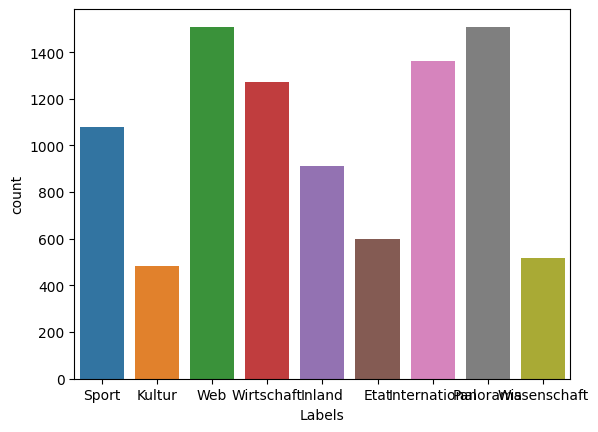

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Labels', data=df1)

Read Testing Dataset and give the distribution of classes.

In [5]:
df2 = pd.read_csv('/content/German Testing dataset.csv')
#df1 = df1.drop('Unnamed: 2', axis=1) # dropped extra unnamed column
df2 = df2.dropna() # dropped blank rows if any

duplicates = df2[df2.duplicated()]
print(duplicates)

df2 = df2.drop_duplicates()
print(df2)

Empty DataFrame
Columns: [Labels, Article]
Index: []
             Labels                                            Article
0        Wirtschaft  'Die Gewerkschaft GPA-djp lanciert den "All-in...
1             Sport  Franzosen verteidigen 2:1-Führung – Kritische ...
2               Web  'Neues Video von Designern macht im Netz die R...
3             Sport  23-jähriger Brasilianer muss vier Spiele pausi...
4     International  Aufständische verwendeten Chemikalie bei Gefec...
...             ...                                                ...
1023            Web  Programm "Ebay Plus" soll Ende September start...
1024         Inland  Fehlerhafte Bilanz 2013, Partei will berufen –...
1025          Sport  Als erster Olympia-Champion auch Hawaii-Sieger...
1026          Sport  Der Außenseiter aus Denver gewinnt die 50. Sup...
1027            Web  Wohl keine Einschränkungen bei Google-Services...

[1027 rows x 2 columns]


<Axes: xlabel='Labels', ylabel='count'>

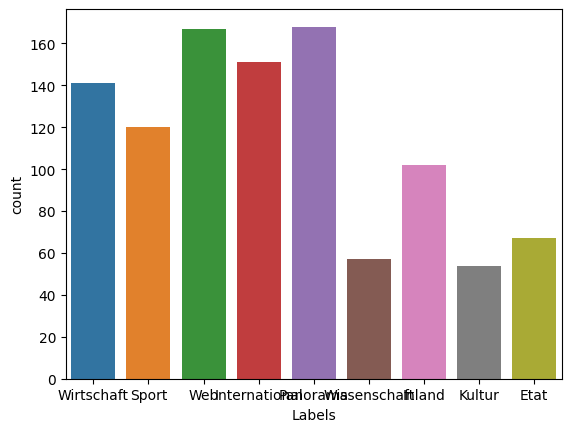

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Labels', data=df2)

Training and Testing Comparison


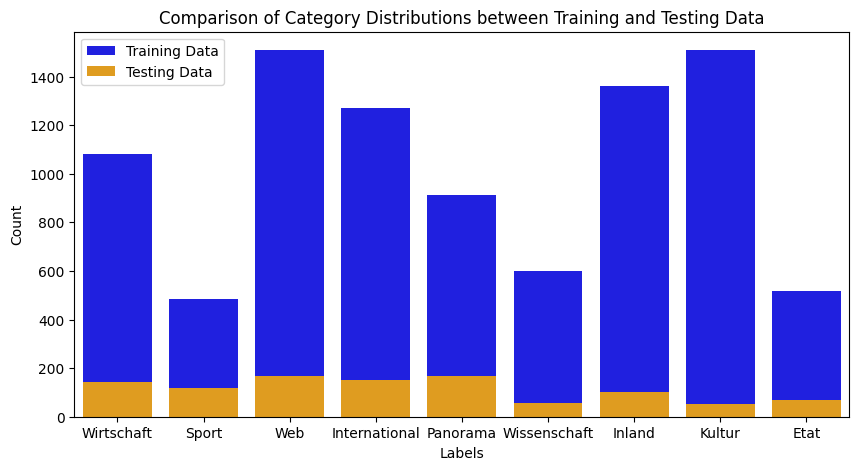

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting training and testing data on the same bar plot
plt.figure(figsize=(10,5))
sns.countplot(data=df1, x='Labels', color='blue', label='Training Data')
sns.countplot(data=df2, x='Labels', color='orange', label='Testing Data')
plt.title('Comparison of Category Distributions between Training and Testing Data')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend()
plt.show()

**Main Dataset** - Concatenation of Training & Testing files


In [8]:
import pandas as pd

# Assuming train_df and test_df are your training and testing DataFrames
# Concatenate the two DataFrames
df = pd.concat([df1, df2], ignore_index=True)

duplicates = df[df.duplicated()]
print(duplicates)

df = df.drop_duplicates()
print(df)

      Labels                                            Article
9971  Inland  Gemeindeergebnisse, Mandate und mögliche Koali...
           Labels                                            Article
0           Sport  21-Jähriger fällt wohl bis Saisonende aus. Wie...
1          Kultur  Erfundene Bilder zu Filmen, die als verloren g...
2             Web  Der frischgekürte CEO Sundar Pichai setzt auf ...
3      Wirtschaft  Putin: "Einigung, dass wir Menge auf Niveau vo...
4          Inland  Estland sieht den künftigen österreichischen P...
...           ...                                                ...
10266         Web  Programm "Ebay Plus" soll Ende September start...
10267      Inland  Fehlerhafte Bilanz 2013, Partei will berufen –...
10268       Sport  Als erster Olympia-Champion auch Hawaii-Sieger...
10269       Sport  Der Außenseiter aus Denver gewinnt die 50. Sup...
10270         Web  Wohl keine Einschränkungen bei Google-Services...

[10270 rows x 2 columns]


<Axes: xlabel='Labels', ylabel='count'>

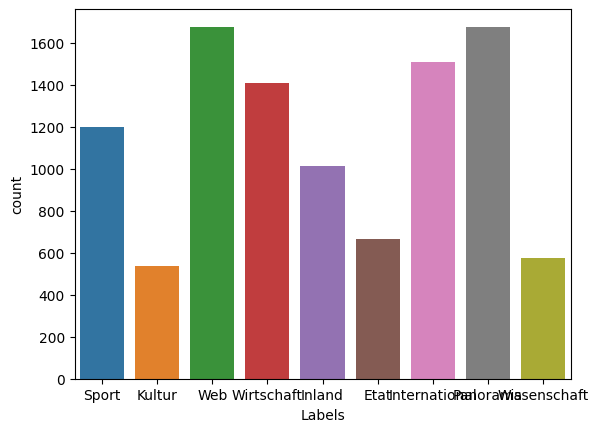

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='Labels', data=df)

<Axes: >

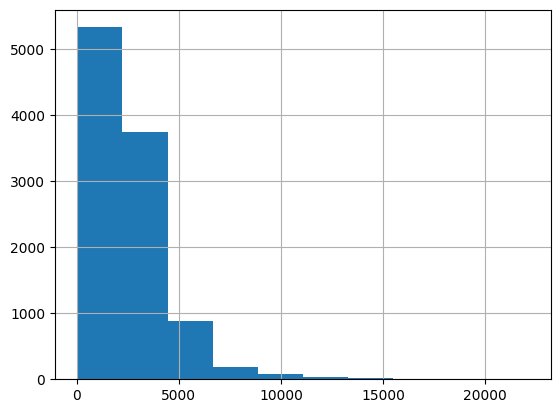

In [10]:
df['Article'].str.len().hist()
#The histogram shows that news headlines range from 1 to 15kk characters and generally,
#it is between 1 to 6k characters.


Calculate Avg. Length of articles

In [11]:
article_texts = df['Article']
article_lengths = []
# Calculate the length of each article and store it in the list
for text in article_texts:
    # You can choose to calculate length based on words or characters
    # For word count, use len(text.split())
    # For character count, use len(text)
    article_lengths.append(len(text.split()))  # Calculating based on words
   # article_lengths.append(len(text))            # Calculating based on characters
# Calculate the average length
average_length = sum(article_lengths) / len(article_lengths)
print(article_lengths)
print(f'Average article length: {average_length:.2f} words')

[63, 577, 277, 97, 619, 222, 64, 237, 124, 418, 273, 275, 193, 171, 644, 226, 685, 205, 536, 98, 224, 318, 252, 827, 260, 581, 465, 438, 263, 217, 462, 315, 296, 691, 230, 517, 144, 184, 498, 574, 118, 410, 2028, 295, 342, 292, 323, 1401, 679, 166, 345, 560, 1203, 413, 519, 479, 223, 106, 615, 165, 551, 232, 327, 99, 675, 266, 643, 177, 910, 102, 318, 271, 369, 2637, 730, 268, 659, 150, 197, 214, 115, 832, 389, 248, 448, 90, 525, 304, 299, 211, 478, 482, 251, 444, 342, 339, 380, 148, 216, 57, 93, 286, 371, 243, 587, 628, 76, 112, 382, 248, 632, 130, 120, 254, 178, 451, 571, 524, 864, 169, 468, 262, 331, 867, 127, 592, 325, 318, 433, 625, 281, 290, 262, 348, 626, 562, 154, 374, 734, 215, 934, 162, 287, 318, 290, 364, 452, 388, 293, 349, 59, 843, 393, 499, 470, 219, 192, 120, 265, 244, 487, 365, 717, 333, 600, 130, 378, 233, 523, 301, 390, 349, 466, 271, 514, 429, 389, 733, 141, 88, 201, 222, 79, 497, 372, 165, 223, 309, 39, 114, 119, 1194, 240, 399, 26, 205, 177, 201, 151, 273, 126, 255

In [12]:
category_count = df['Labels'].value_counts()

categories = category_count.index

categories

Index(['Panorama', 'Web', 'International', 'Wirtschaft', 'Sport', 'Inland',
       'Etat', 'Wissenschaft', 'Kultur'],
      dtype='object')

In [13]:
df['encoded_text'] = df['Labels'].astype('category').cat.codes

df.head(10)
print(df)

           Labels                                            Article  \
0           Sport  21-Jähriger fällt wohl bis Saisonende aus. Wie...   
1          Kultur  Erfundene Bilder zu Filmen, die als verloren g...   
2             Web  Der frischgekürte CEO Sundar Pichai setzt auf ...   
3      Wirtschaft  Putin: "Einigung, dass wir Menge auf Niveau vo...   
4          Inland  Estland sieht den künftigen österreichischen P...   
...           ...                                                ...   
10266         Web  Programm "Ebay Plus" soll Ende September start...   
10267      Inland  Fehlerhafte Bilanz 2013, Partei will berufen –...   
10268       Sport  Als erster Olympia-Champion auch Hawaii-Sieger...   
10269       Sport  Der Außenseiter aus Denver gewinnt die 50. Sup...   
10270         Web  Wohl keine Einschränkungen bei Google-Services...   

       encoded_text  
0                 5  
1                 3  
2                 6  
3                 7  
4                 1  
...

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named df with 'Labels' and 'Article' columns

# Step 1: Group by unique labels
grouped = df.groupby('encoded_text')

# Step 2: Make 9 subsets
subsets = {label: group for label, group in grouped}

# Initialize empty lists for 80% and 20% subsets
subsets_80 = []
subsets_20 = []

# Step 3 and 4: Split 80% and 20%, then merge into DataFrames
for label, group in subsets.items():
    subset_80, subset_20 = train_test_split(group, train_size=0.8, random_state=42)
    subsets_80.append(subset_80)
    subsets_20.append(subset_20)

# Concatenate subsets into DataFrames
combined_subset_80 = pd.concat(subsets_80, ignore_index=True)
combined_subset_20 = pd.concat(subsets_20, ignore_index=True)

# Step 5: Separate labels and articles
train_texts = combined_subset_80['Article'].to_list()
train_labels = combined_subset_80['encoded_text'].to_list()

test_texts = combined_subset_20['Article'].to_list()
test_labels = combined_subset_20['encoded_text'].to_list()


In [15]:
from transformers import XLMRobertaForSequenceClassification
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

train_encodings = tokenizer(train_texts, truncation = True, padding = True)

test_encodings = tokenizer(test_texts, truncation = True, padding = True)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))


test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [17]:
from transformers import AutoTokenizer, XLMRobertaModel
model = XLMRobertaModel.from_pretrained("xlm-roberta-base",num_labels=9)

In [18]:
max_len = 512   #max_length (int, optional, defaults to 20) — Maximum length that will be used by default in the generate method of the model.


model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0, input_shape=(max_len,)),
    tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=32, input_length=max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(9, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

train_sequences = [tokenizer.encode(text, max_length=max_len, truncation=True) for text in train_texts]
train_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_len, padding='post')

train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=9)

model.fit(train_sequences_padded, train_labels_onehot, epochs=20, batch_size=32)

Epoch 1/20
257/257 [==============================] - 33s 124ms/step - loss: 2.1377 - accuracy: 0.1773
Epoch 2/20
257/257 [==============================] - 27s 107ms/step - loss: 2.0932 - accuracy: 0.2393
Epoch 3/20
257/257 [==============================] - 29s 113ms/step - loss: 2.0642 - accuracy: 0.2695
Epoch 4/20
257/257 [==============================] - 29s 114ms/step - loss: 2.0327 - accuracy: 0.2712
Epoch 5/20
257/257 [==============================] - 28s 109ms/step - loss: 1.9991 - accuracy: 0.2687
Epoch 6/20
257/257 [==============================] - 28s 110ms/step - loss: 1.9622 - accuracy: 0.2744
Epoch 7/20
257/257 [==============================] - 28s 108ms/step - loss: 1.9186 - accuracy: 0.3158
Epoch 8/20
257/257 [==============================] - 32s 125ms/step - loss: 1.8636 - accuracy: 0.3957
Epoch 9/20
257/257 [==============================] - 28s 108ms/step - loss: 1.7940 - accuracy: 0.4818
Epoch 10/20
257/257 [==============================] - 29s 111ms/step - l

In [19]:
test_text = test_texts[7]
test_text

'Kolumnist Bag rechnet, dass es regierungskritische Zeitung in wenigen Wochen nicht mehr geben wird. Ankara/Berlin/Wien – Als einen Akt des staatlichen Terrors bezeichnet Süleyman Bag die Zwangsübernahme der türkischen Tageszeitung Zaman und der Nachrichtenagentur Cihan durch die konservativ-islamische Regierung von Staatspräsident Recep Tayyip Erdogan. Der Chefredakteur der deutsch-türkischen Plattform DTJ-Online, Zaman-Kolumnist und frühere Chefredakteur von Zaman Deutschland war am Montag auf Besuch in Wien. Am 4. März, kurz vor Mitternacht, stürmte die türkische Polizei das Gebäude von Zaman, ging mit Wasserwerfern, Tränengas und Platzpatronen gegen friedliche Demonstranten vor. Mit der feindlichen Übernahme hat die Pressefreiheit in der Türkei einen neuen Tiefpunkt erreicht, kommentiert Bag die Ereignisse, durch die die regierungskritischen Medien ausgeschaltet wurden. Druck auf Journalisten werde unter Erdogan systematisch ausgeübt, sagt Bag. Wie jetzt mit Zaman und Cihan verfuhr

In [20]:
predict_input = [tokenizer.encode(text, max_length=max_len, truncation=True) for text in [test_text]]
predict_input_padded = tf.keras.preprocessing.sequence.pad_sequences(predict_input, maxlen=max_len, padding='post')
output = model(predict_input_padded)[0]
prediction_value = tf.argmax(output, axis=-1).numpy()
prediction_value


2

In [21]:

# Prepare test data
test_sequences = [tokenizer.encode(text, max_length=max_len, truncation=True) for text in test_texts]
test_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding='post')
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=9)

# Make predictions on test data
y_pred = model.predict(test_sequences_padded)
y_pred = np.argmax(y_pred, axis=1)



65/65 [==============================] - 0s 3ms/step


[[ 21   8   9   6  16   8  52  11   3]
 [  3  98   6   0  60   1  11  23   1]
 [  0   5 237   1  41   0   3  16   0]
 [  8   4   6  30  13   8  31   5   3]
 [  0  22  41   2 235   2  14  19   1]
 [  0   0   1   0   6 229   3   2   0]
 [  2   0   8   2  10   1 295  18   0]
 [  2   6  13   0  32   2  33 195   0]
 [  4   5  10   6  17   0  27   8  38]]
Accuracy: 66.926
Classification report:
              precision    recall  f1-score   support

           0      0.525     0.157     0.241       134
           1      0.662     0.483     0.558       203
           2      0.716     0.782     0.748       303
           3      0.638     0.278     0.387       108
           4      0.547     0.699     0.614       336
           5      0.912     0.950     0.931       241
           6      0.629     0.878     0.733       336
           7      0.657     0.689     0.672       283
           8      0.826     0.330     0.472       115

    accuracy                          0.669      2059
   macro avg

Text(20.72222222222222, 0.5, 'Predicted value')

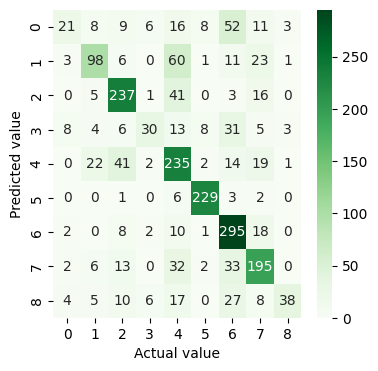

In [22]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matrix = confusion_matrix(test_labels, y_pred)
print(matrix)

# Calculate metrics
accuracy = np.mean(y_pred == test_labels)
accuracy= accuracy*100
report = classification_report(test_labels, y_pred, digits=3)

print(f"Accuracy: {accuracy:.3f}")
print(f"Classification report:\n{report}")


# Heat Map
plt.figure(figsize=(4,4))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
